In [1]:
# SETUP
import torch
import random
import os

import sys
sys.path.insert(0,'..')
torch.cuda.empty_cache()

from dataloader import CustomDataloader
from model import VaeClassifier
from train import setup_and_train
from utils import load_params, load_model

# set random seed for reproducibility.
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

# use GPU if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, "will be used.")

Random Seed:  1123
cuda:0 will be used.
Number of interop threads used: 8
Number of threads used: 8
------------------------- 

Random Seed:  1123
cuda:0 will be used.


In [2]:
# Trained verification pipeline loading
def get_params(path, only_cla):
    config_file = os.path.join(os.path.dirname(os.path.dirname(path)), "config.txt")
    params, _ = load_params(config_file)
    dataloader = CustomDataloader(params['dataset'], datasets_dir="../data")
    classes, attributes = dataloader.get_dataset_params(["classes", "attributes"])
    params['model']['cla_args'] = {'num_classes': len(classes)}
    params['model']['classifier_path' if only_cla else 'model_path'] = path
    return params, attributes

vae_cla_path = "" # fill in path to a SRVP/VAE_CLA model
params, attributes = get_params(vae_cla_path, only_cla=False)
vae_cla = VaeClassifier(params['model'], device, attributes).to(device)
load_model(vae_cla, params['model'], device)

Loading params from ../beast_results/TrafficSignsDynSynth/2023-01-26/19:40:12_TRDS_resnet/config.txt
Latent dims: 256
--------------------
Classes: ['diverge', 'minus', 'no_uturn', 'speed_50', 'stop', 'turn_left', 'turn_right']
Conditioning attributes: [['left_shear', 'right_shear', 'left_rotate', 'right_rotate', 'towards', 'far']]
Conditional losses: ['CE'] (total conditional_ldims: 6)


/home/hh/Documents/tutorials/ML_pytorch_exps/pytorch_exps_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/hh/Documents/tutorials/ML_pytorch_exps/pytorch_exps_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)




-------------------------
Feature Detection Network
-------------------------


-------------------------
Classification Head
-------------------------


-------------------------
Encoding Head
-------------------------


-------------------------
Decoder
-------------------------


-------------------------
Model inversion verified w.r.t 0.001 (maximum inversion difference was 8.65085780787922e-13)
-------------------------
Loading MODEL from ../beast_results/TrafficSignsDynSynth/2023-01-26/19:40:12_TRDS_resnet/models/Epoch_9_acc_1.00_vaeloss_436.68.tar


In [4]:
# get corresponding dataset to play with
dataloader = CustomDataloader(params['dataset'], datasets_dir="../data")
_, _, test_dl = dataloader.get_data(params['dataset']['batch_size'])
latent_dims = params['model']['latent_dim']
classes, attributes, conditional_ldims = dataloader.get_dataset_params(["classes", "attributes", "conditional_ldims"])

--------------------
Classes: ['diverge', 'minus', 'no_uturn', 'speed_50', 'stop', 'turn_left', 'turn_right']
Conditioning attributes: [['left_shear', 'right_shear', 'left_rotate', 'right_rotate', 'towards', 'far']]
Conditional losses: ['CE'] (total conditional_ldims: 6)
--------------------
Dataset: TrafficSignsDynSynth
Batch Size: 16
Training Batches: 1030
Validation Batches: 11
Test Batches: 11
--------------------


In [5]:
# Visualizations setup
import numpy as np
%matplotlib nbagg
import matplotlib
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 150;plt.rc('font', **{'size': 8})
from matplotlib.widgets import Slider
from torchvision.utils import make_grid
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

from utils import get_conditional_limits
from visualizations import get_colors_and_legend, produce_embeddings, plots_embeddings, interpolate_embeddings, random_eps_ball_embeddings

x_set, z_set, y_set, x_feat_set = produce_embeddings(test_dl, vae_cla, device, num_batches=20)

<IPython.core.display.Javascript object>


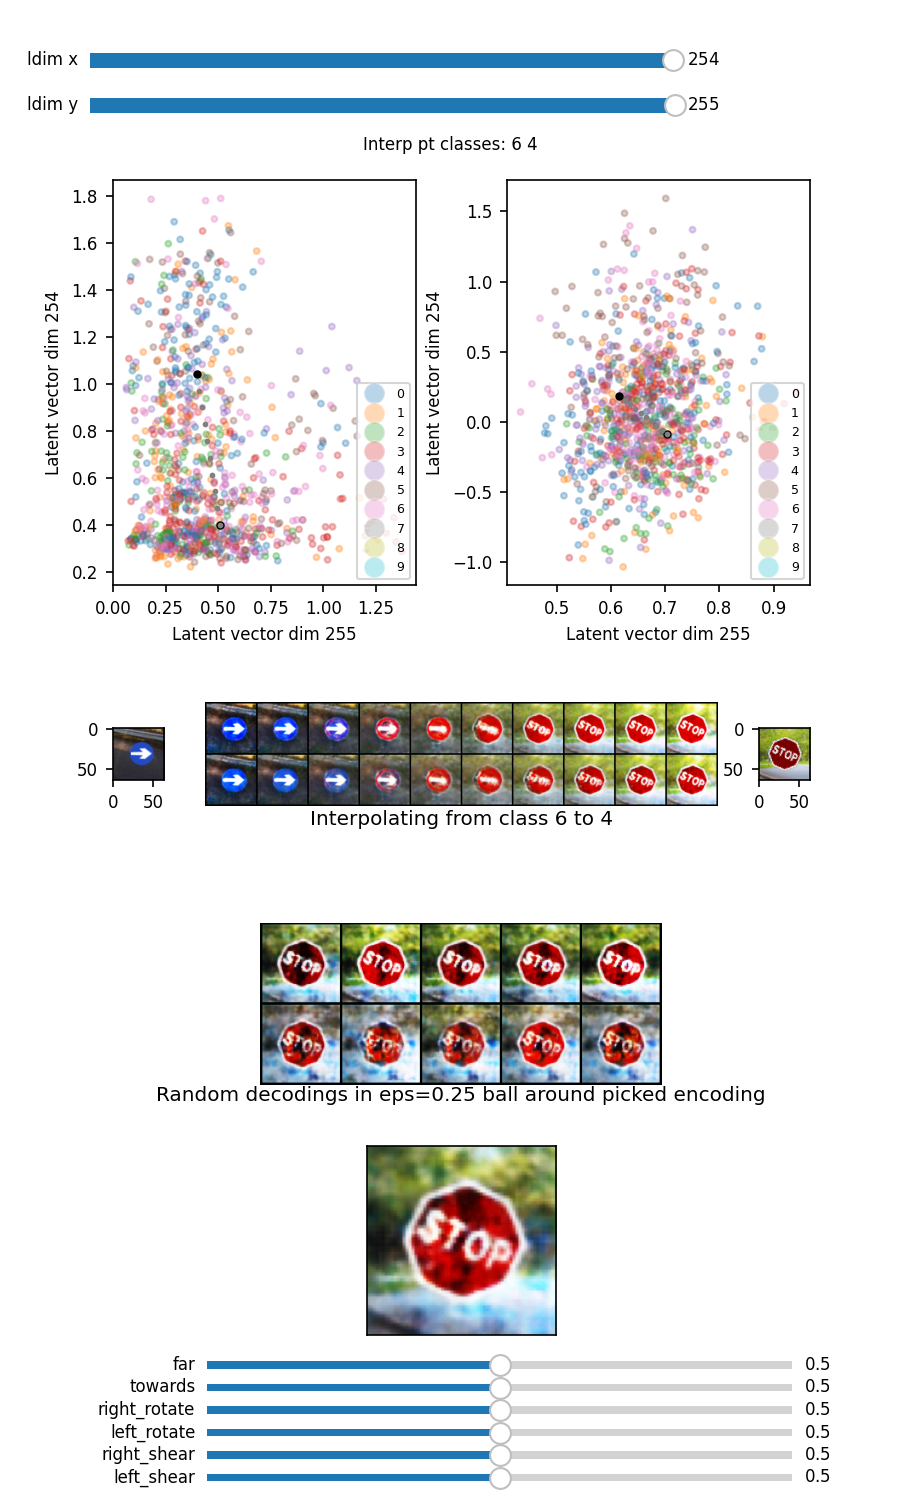

In [14]:
# plot interpolations (Segment query visualizations)
ninterps= 10
    
def sliders_on_changed(val):
    # latent dimensions to visualize
    global sliders, interp_pts, interp_pts_text
    interp_pts = []
    interp_pts_text.set_text("")
    plots_embeddings([x_feat_axis, z_axis], y_set, x_feat_set, z_set, sliders[0].val, sliders[1].val)

def csliders_on_changed(val=None):
    # set condition dimension values
    global csliders, interp_pts
    if len(interp_pts) == 0:
        return
    z = interp_pts[-1]["z"]
    for i, cslider in enumerate(csliders):
        z[i] = cslider.val
    recons = vae_cla.decoder(z.unsqueeze(0).to(device)).to('cpu').detach()
    cond_axis.imshow(make_grid(dataloader.denormalize(recons), nrow=1).permute(1, 2, 0))
    cond_axis.axis("on")
    cond_axis.set_xticks([])
    cond_axis.set_yticks([])

def on_pick(event):
    global interp_pts, scatters, line_scatters, sliders, interp_pts_text
    ld1, ld2 = sliders[0].val, sliders[1].val
    ind = event.ind[0]  # if the dots are to close one to another, a list of dots clicked is returned
    
    # 1. segment visualization
    interp_pts = interp_pts[-1:]
    interp_pts.append({"x": x_set[ind], "z": z_set[ind], "y": y_set[ind], "x_feat": x_feat_set[ind]})
    interp_pts_info = "Picked one encoding, click another." if len(interp_pts) == 1 else f"Interpolating b/w {len(interp_pts)} points..."
    interp_pts_text.set_text(interp_pts_info)
    interpolations = interpolate_embeddings(interp_pts, axes2, vae_cla, device, ld1, ld2, ninterps, dataloader.denormalize)
    if len(interpolations) > 0:
        interp_pts_text.set_text(f'Interp pt classes: {interp_pts[0]["y"]} {interp_pts[1]["y"]}')
        # remove previous interp line and plot new one
        for sctr in line_scatters:
            sctr.remove()
        x_line, z_line = interpolations
        x_feat_line_sctr = x_feat_axis.scatter(x_line[:, ld1], x_line[:, ld2], c='gray', s=3)
        z_line_sctr = z_axis.scatter(z_line[:, ld1], z_line[:, ld2], c='gray', s=3)
        line_scatters = [x_feat_line_sctr, z_line_sctr]
    # remove the previously selected endpoints and plot new ones
    for sctr in scatters[:-1]:
        sctr.remove()
    x_feat_sctr = x_feat_axis.scatter(x_feat_set[ind, ld1], x_feat_set[ind, ld2], c='k', s=9)
    z_sctr = z_axis.scatter(z_set[ind, ld1], z_set[ind, ld2], c='k', s=9)
    scatters = scatters[-1:]
    scatters.append([x_feat_sctr, z_sctr])
    # 2. visualize randomly sampled embeddings in a eps-ball around the newly clicked embedding
    random_eps_ball_embeddings(interp_pts[-1], reg_axis, vae_cla, device, 0.25, 5, dataloader.denormalize)
    # 3. prepare for conditional changes around the newly clicked embedding
    csliders_on_changed()
    plt.draw()

fig1 = plt.figure(figsize=(6, 10))
gs = GridSpec(4, 1, height_ratios=[1.5,0.8,0.6,0.7], hspace=0.25)
# for embeddings
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], wspace=0.3)
x_feat_axis = plt.subplot(gs1[0])
z_axis = plt.subplot(gs1[1])
interp_pts_text = fig1.text(0.5, 0.9, 'Click an embedding in either graphs to begin.', ha='center')
fig1.canvas.mpl_connect('pick_event', on_pick)
interp_pts, scatters, line_scatters, sliders = [], [], [], []
for i, (slider_label) in enumerate(['ldim x', 'ldim y']):
    ld_ax  = fig1.add_axes([0.1, 0.95-0.03*i, 0.65, 0.02], facecolor='lightgoldenrodyellow')
    slider = Slider(ld_ax, slider_label, valmin=0, valmax=latent_dims-1, valinit=latent_dims-2+i, valstep=1)
    slider.on_changed(sliders_on_changed)
    sliders.append(slider)
plots_embeddings([x_feat_axis, z_axis], y_set, x_feat_set, z_set, latent_dims-2, latent_dims-1)
# for segment queries visualization
gs2 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], width_ratios=[1, ninterps, 1])
axes2 = [plt.subplot(gs2[0]), plt.subplot(gs2[1]), plt.subplot(gs2[2])]
for ax in axes2:
    ax.axis("off")
# for changes in eps region
gs3 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[2])
reg_axis = plt.subplot(gs3[0])
reg_axis.axis("off")
# for conditional changes
gs4 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[3])
cond_axis = plt.subplot(gs4[0])
cond_axis.axis("off")
csliders = []
cond_dims_setpts, cond_dim_labels = get_conditional_limits(dataloader)
for i, (slimits, slabel) in enumerate(zip(cond_dims_setpts, cond_dim_labels)):
    ld_ax  = fig1.add_axes([0.23, 0.01+0.015*i, 0.65, 0.01], facecolor='lightgoldenrodyellow')
    slider = Slider(ld_ax, slabel, valmin=slimits[0][0], valmax=slimits[-1][-1], valinit=(slimits[0][0]+slimits[-1][-1])/2, valstep=0.25)
    slider.on_changed(csliders_on_changed)
    csliders.append(slider)